# Inference: using saved pipeline on a new data

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/tinkoff-ai/etna/master?filepath=examples/302-inference.ipynb)

This notebook contains the example of usage already fitted and saved pipeline on a new data.

**Table of contents**

* [Preparing data](#chapter1)
* [Fitting and saving pipeline](#chapter2)
    * [Fitting pipeline](#section_2_1)
    * [Saving pipeline](#section_2_2)
    * [Method to_dict](#section_2_3)
* [Using saved pipeline on a new data](#chapter3)
    * [Loading pipeline](#section_3_1)
    * [Forecast on a new data](#section_3_2)

In [1]:
import warnings

warnings.filterwarnings(action="ignore", message="Torchmetrics v0.9")

In [2]:
import pathlib

import pandas as pd

from etna.analysis import plot_forecast
from etna.datasets import TSDataset
from etna.metrics import SMAPE
from etna.models import CatBoostMultiSegmentModel
from etna.pipeline import Pipeline
from etna.transforms import DateFlagsTransform
from etna.transforms import LagTransform
from etna.transforms import LogTransform
from etna.transforms import SegmentEncoderTransform

In [3]:
HORIZON = 30
SAVE_DIR = pathlib.Path("tmp")
SAVE_DIR.mkdir(exist_ok=True)

## 1. Preparing data <a class="anchor" id="chapter1"></a>

Let's load data and prepare it for our pipeline.

In [4]:
df = pd.read_csv("data/example_dataset.csv")
df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279


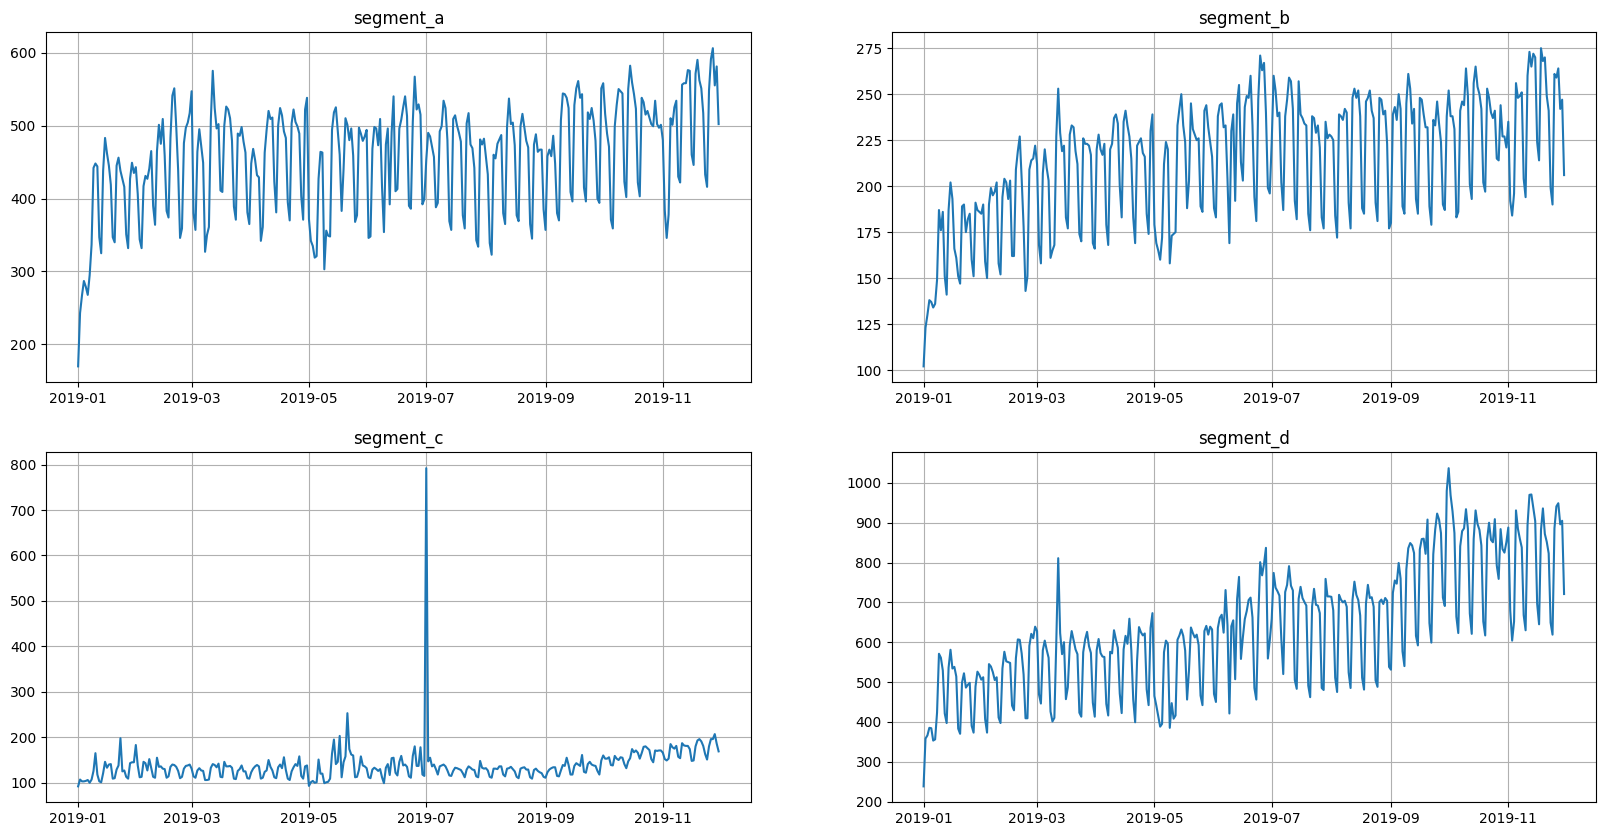

In [5]:
df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq="D")
ts.plot()

We want to make two versions of data: old and new. New version should include more timestamps.

In [6]:
new_ts, test_ts = ts.train_test_split(test_size=HORIZON)
old_ts, _ = ts.train_test_split(test_size=HORIZON * 3)

Let's visualize them.

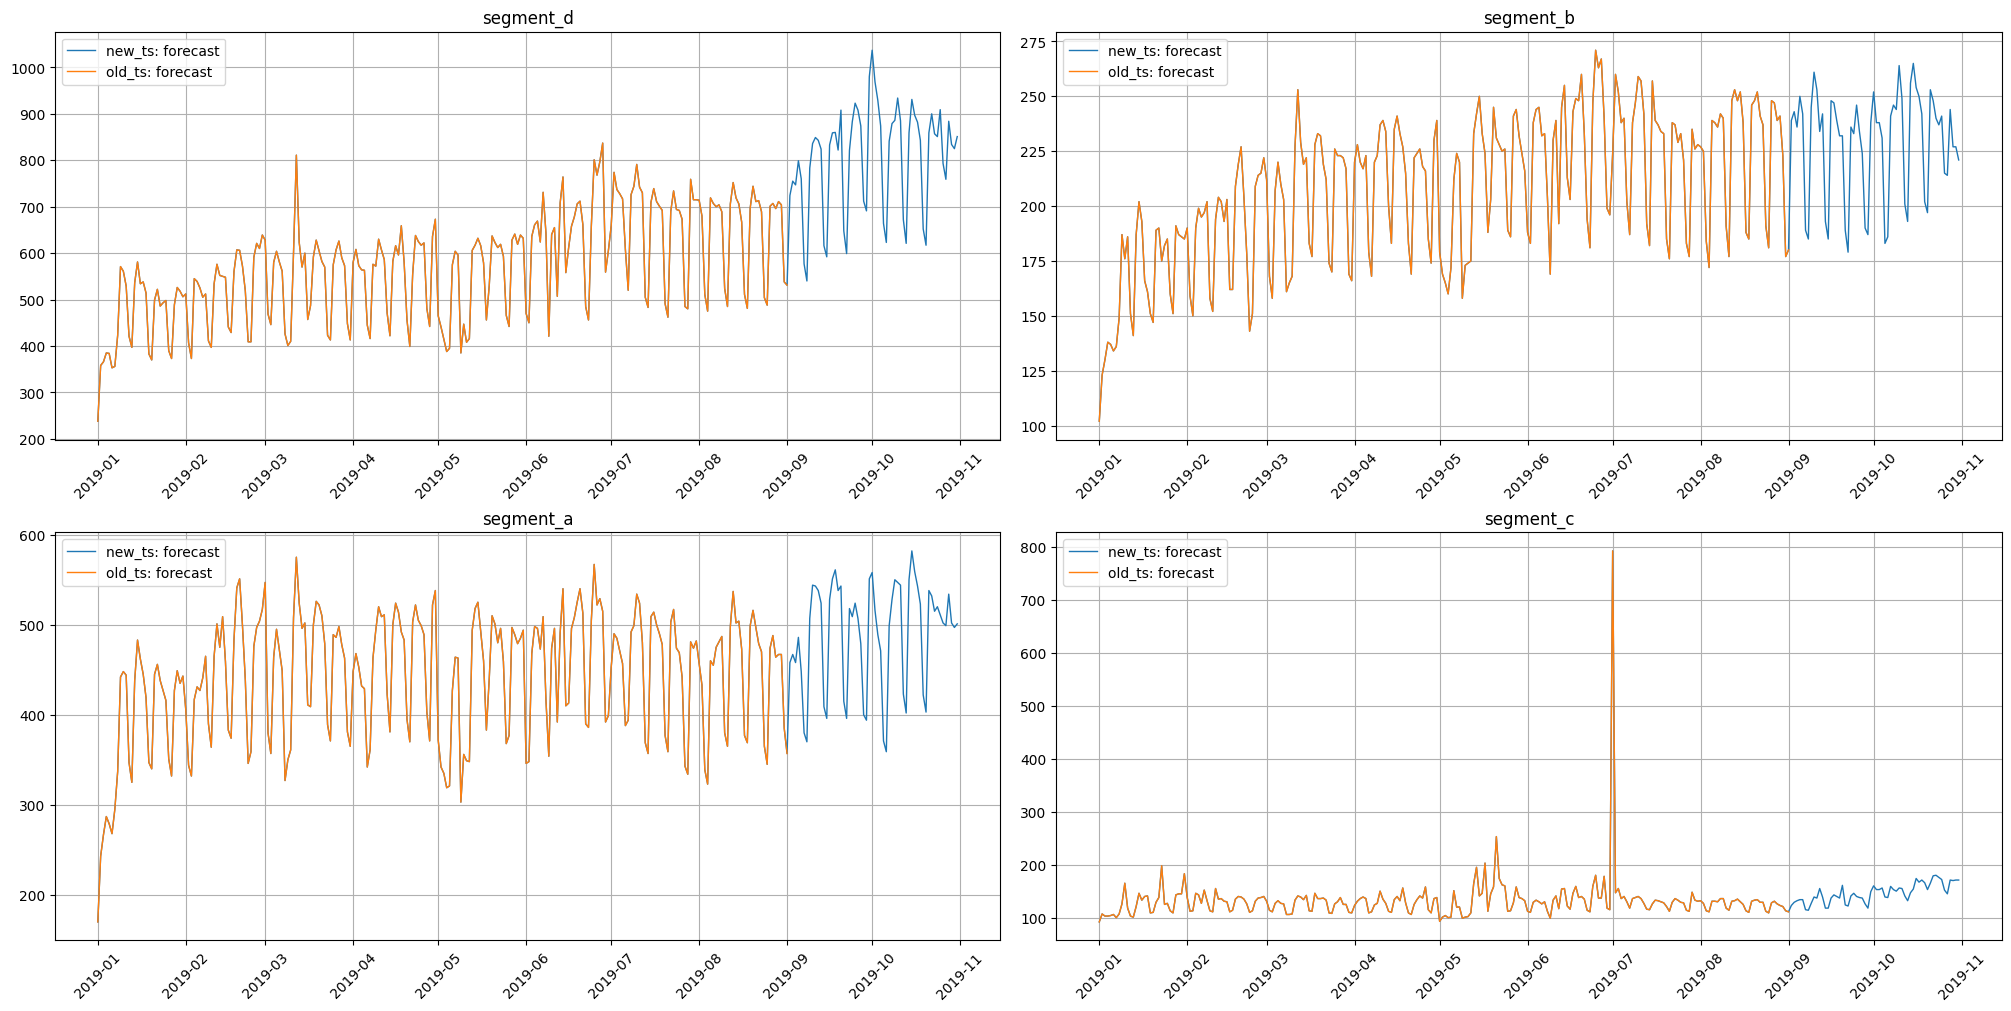

In [7]:
plot_forecast(forecast_ts={"new_ts": new_ts, "old_ts": old_ts})

## 2. Fitting and saving pipeline <a class="anchor" id="chapter2"></a>

### 2.1 Fitting pipeline <a class="anchor" id="section_2_1"></a>

Here we fit our pipeline on `old_ts`.

In [8]:
log = LogTransform(in_column="target")
seg = SegmentEncoderTransform()
lags = LagTransform(in_column="target", lags=list(range(HORIZON, 96)), out_column="lag")
date_flags = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=True,
    month_number_in_year=True,
    is_weekend=False,
    out_column="date_flag",
)

model = CatBoostMultiSegmentModel()
transforms = [log, seg, lags, date_flags]
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

In [9]:
pipeline.fit(old_ts)

Pipeline(model = CatBoostMultiSegmentModel(iterations = None, depth = None, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ), SegmentEncoderTransform(), LagTransform(in_column = 'target', lags = [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95], out_column = 'lag', ), DateFlagsTransform(day_number_in_week = True, day_number_in_month = True, day_number_in_year = False, week_number_in_month = False, week_number_in_year = False, month_number_in_year = True, season_number = False, year_number = False, is_weekend = False, special_days_in_week = (), special_days_in_month = (), out_column = 'date_flag', )], horizon = 30, )

### 2.2 Saving pipeline <a class="anchor" id="section_2_2"></a>

Let's save ready pipeline to disk.

In [10]:
pipeline.save(SAVE_DIR / "pipeline.zip")

Currently, we can't save `TSDataset`. But model and transforms are successfully saved. We can also save models and transforms separately exactly like we saved our pipeline.

In [11]:
model.save(SAVE_DIR / "model.zip")
transforms[0].save(SAVE_DIR / "transform_0.zip")

In [12]:
!ls tmp

model.zip  pipeline.zip  transform_0.zip


### 2.3 Method `to_dict` <a class="anchor" id="section_2_3"></a>

Method `save` shouldn't be confused with method `to_dict`. The first is used to save object with its inner state to disk, e.g. fitted catboost model. The second is used to form a representation that can be used to recreate the object with the same initialization parameters.

In [13]:
pipeline.to_dict()

{'model': {'logging_level': 'Silent',
  'kwargs': {},
  '_target_': 'etna.models.catboost.CatBoostMultiSegmentModel'},
 'transforms': [{'in_column': 'target',
   'base': 10,
   'inplace': True,
   '_target_': 'etna.transforms.math.log.LogTransform'},
  {'_target_': 'etna.transforms.encoders.segment_encoder.SegmentEncoderTransform'},
  {'in_column': 'target',
   'lags': [30,
    31,
    32,
    33,
    34,
    35,
    36,
    37,
    38,
    39,
    40,
    41,
    42,
    43,
    44,
    45,
    46,
    47,
    48,
    49,
    50,
    51,
    52,
    53,
    54,
    55,
    56,
    57,
    58,
    59,
    60,
    61,
    62,
    63,
    64,
    65,
    66,
    67,
    68,
    69,
    70,
    71,
    72,
    73,
    74,
    75,
    76,
    77,
    78,
    79,
    80,
    81,
    82,
    83,
    84,
    85,
    86,
    87,
    88,
    89,
    90,
    91,
    92,
    93,
    94,
    95],
   'out_column': 'lag',
   '_target_': 'etna.transforms.math.lags.LagTransform'},
  {'day_number_in_we

In [14]:
model.to_dict()

{'logging_level': 'Silent',
 'kwargs': {},
 '_target_': 'etna.models.catboost.CatBoostMultiSegmentModel'}

In [15]:
transforms[0].to_dict()

{'in_column': 'target',
 'base': 10,
 'inplace': True,
 '_target_': 'etna.transforms.math.log.LogTransform'}

To recreate the object from generated dictionary we can use a `hydra_slayer` library.

In [16]:
from hydra_slayer import get_from_params

get_from_params(**transforms[0].to_dict())

LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, )

## 3. Using saved pipeline on a new data <a class="anchor" id="chapter3"></a>

### 3.1 Loading pipeline <a class="anchor" id="section_3_1"></a>

Let's load saved pipeline.

In [17]:
from etna.core import load

pipeline_loaded = load(SAVE_DIR / "pipeline.zip", ts=new_ts)
pipeline_loaded

Pipeline(model = CatBoostMultiSegmentModel(iterations = None, depth = None, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ), SegmentEncoderTransform(), LagTransform(in_column = 'target', lags = [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95], out_column = 'lag', ), DateFlagsTransform(day_number_in_week = True, day_number_in_month = True, day_number_in_year = False, week_number_in_month = False, week_number_in_year = False, month_number_in_year = True, season_number = False, year_number = False, is_weekend = False, special_days_in_week = (), special_days_in_month = (), out_column = 'date_flag', )], horizon = 30, )

Here we explicitly set `ts=new_ts` in `load` function in order to pass it inside our `pipeline_loaded`. Otherwise, `pipeline_loaded` doesn't have `ts` to forecast and we should explicitly call `forecast(ts=new_ts)` for making a forecast.

We can also load saved model and transoform using `load`, but we shouldn't set `ts` parameter, because models and transforms don't need it.

In [18]:
model_loaded = load(SAVE_DIR / "model.zip")
transform_0_loaded = load(SAVE_DIR / "transform_0.zip")

There is an alternative way to load objects using their `classmethod load`.

In [19]:
pipeline_loaded_from_class = Pipeline.load(SAVE_DIR / "pipeline.zip", ts=new_ts)
model_loaded_from_class = CatBoostMultiSegmentModel.load(SAVE_DIR / "model.zip")
transform_0_loaded_from_class = LogTransform.load(SAVE_DIR / "transform_0.zip")

### 3.2 Forecast on a new data <a class="anchor" id="section_3_2"></a>

Use this pipeline for prediction.

In [20]:
forecast_ts = pipeline_loaded.forecast()

/opt/conda/lib/python3.8/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(


Look at predictions.

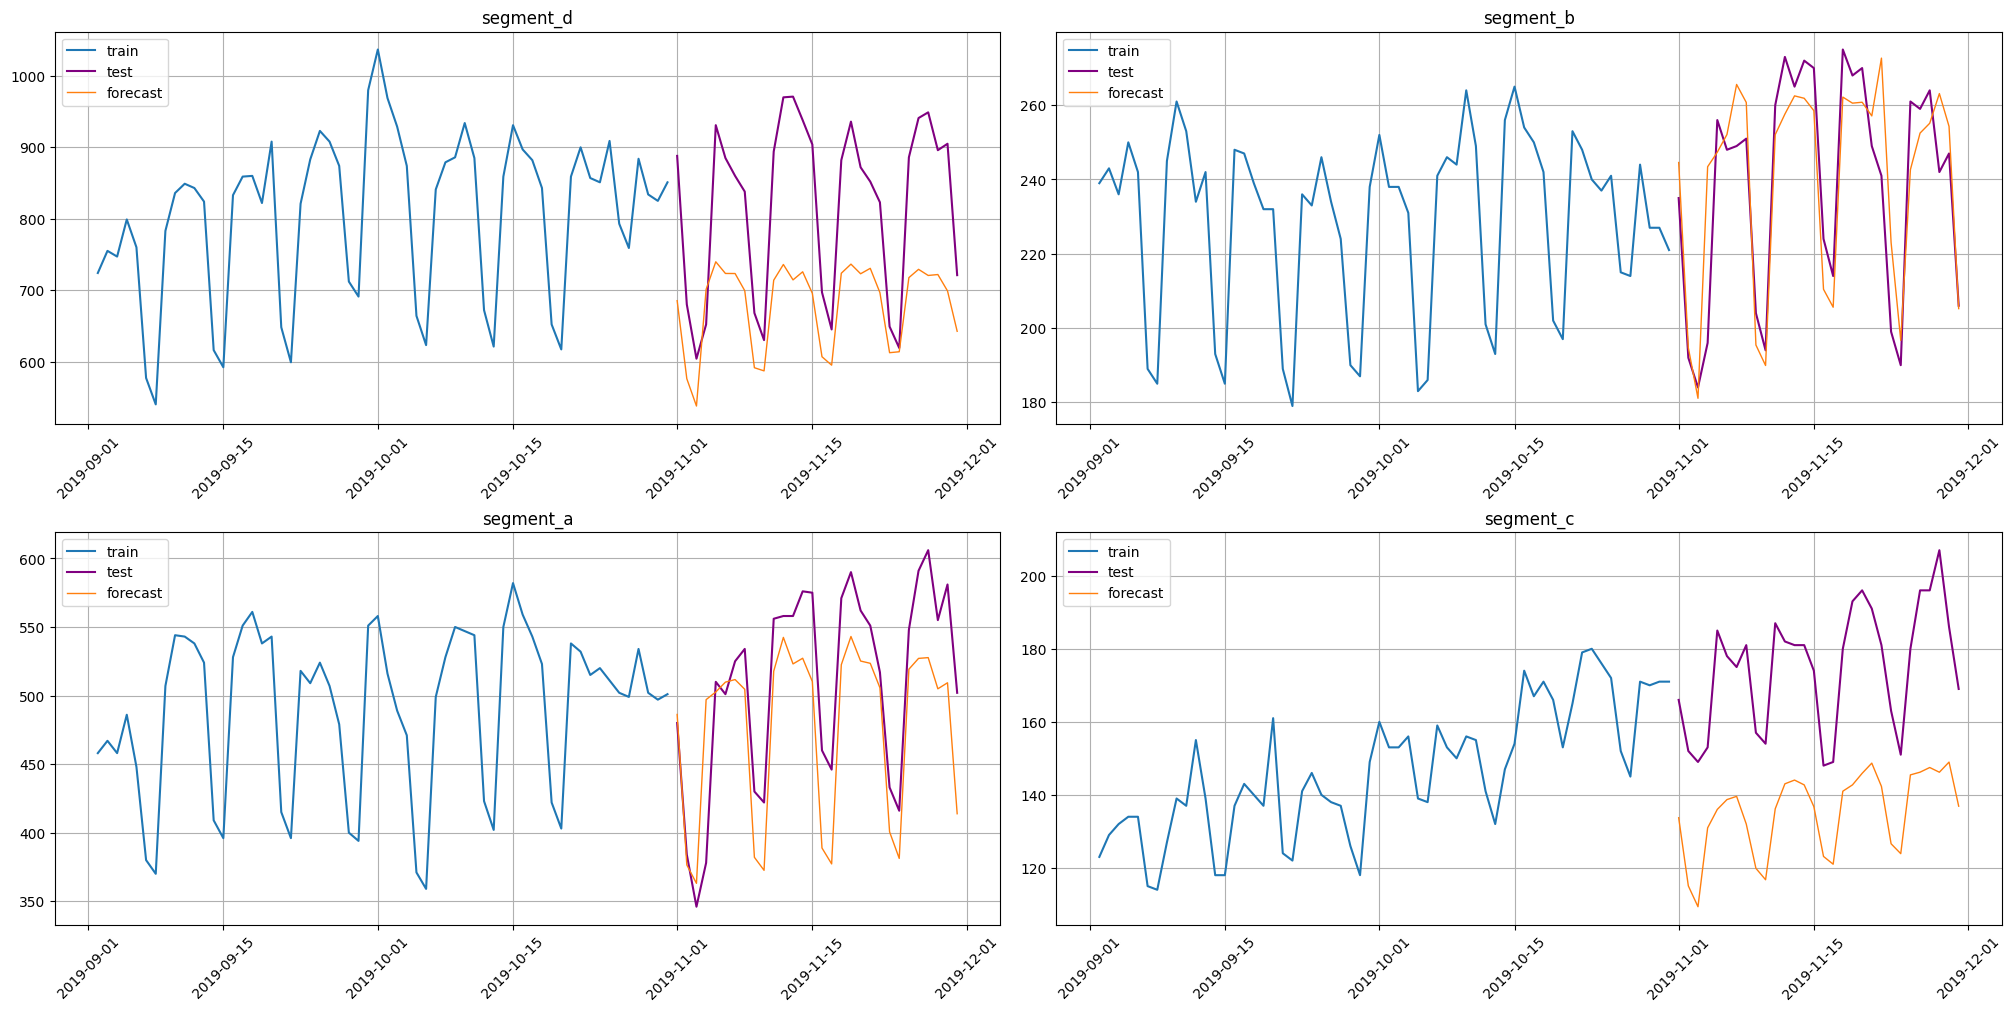

In [21]:
plot_forecast(forecast_ts=forecast_ts, test_ts=test_ts, train_ts=new_ts, n_train_samples=HORIZON * 2)

In [22]:
smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'segment_d': 18.20146757117957,
 'segment_b': 4.828671629496566,
 'segment_a': 8.73107925541017,
 'segment_c': 25.23759225436336}

Let's compare it with metrics of pipeline that was fitted on `new_ts`.

/opt/conda/lib/python3.8/site-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(


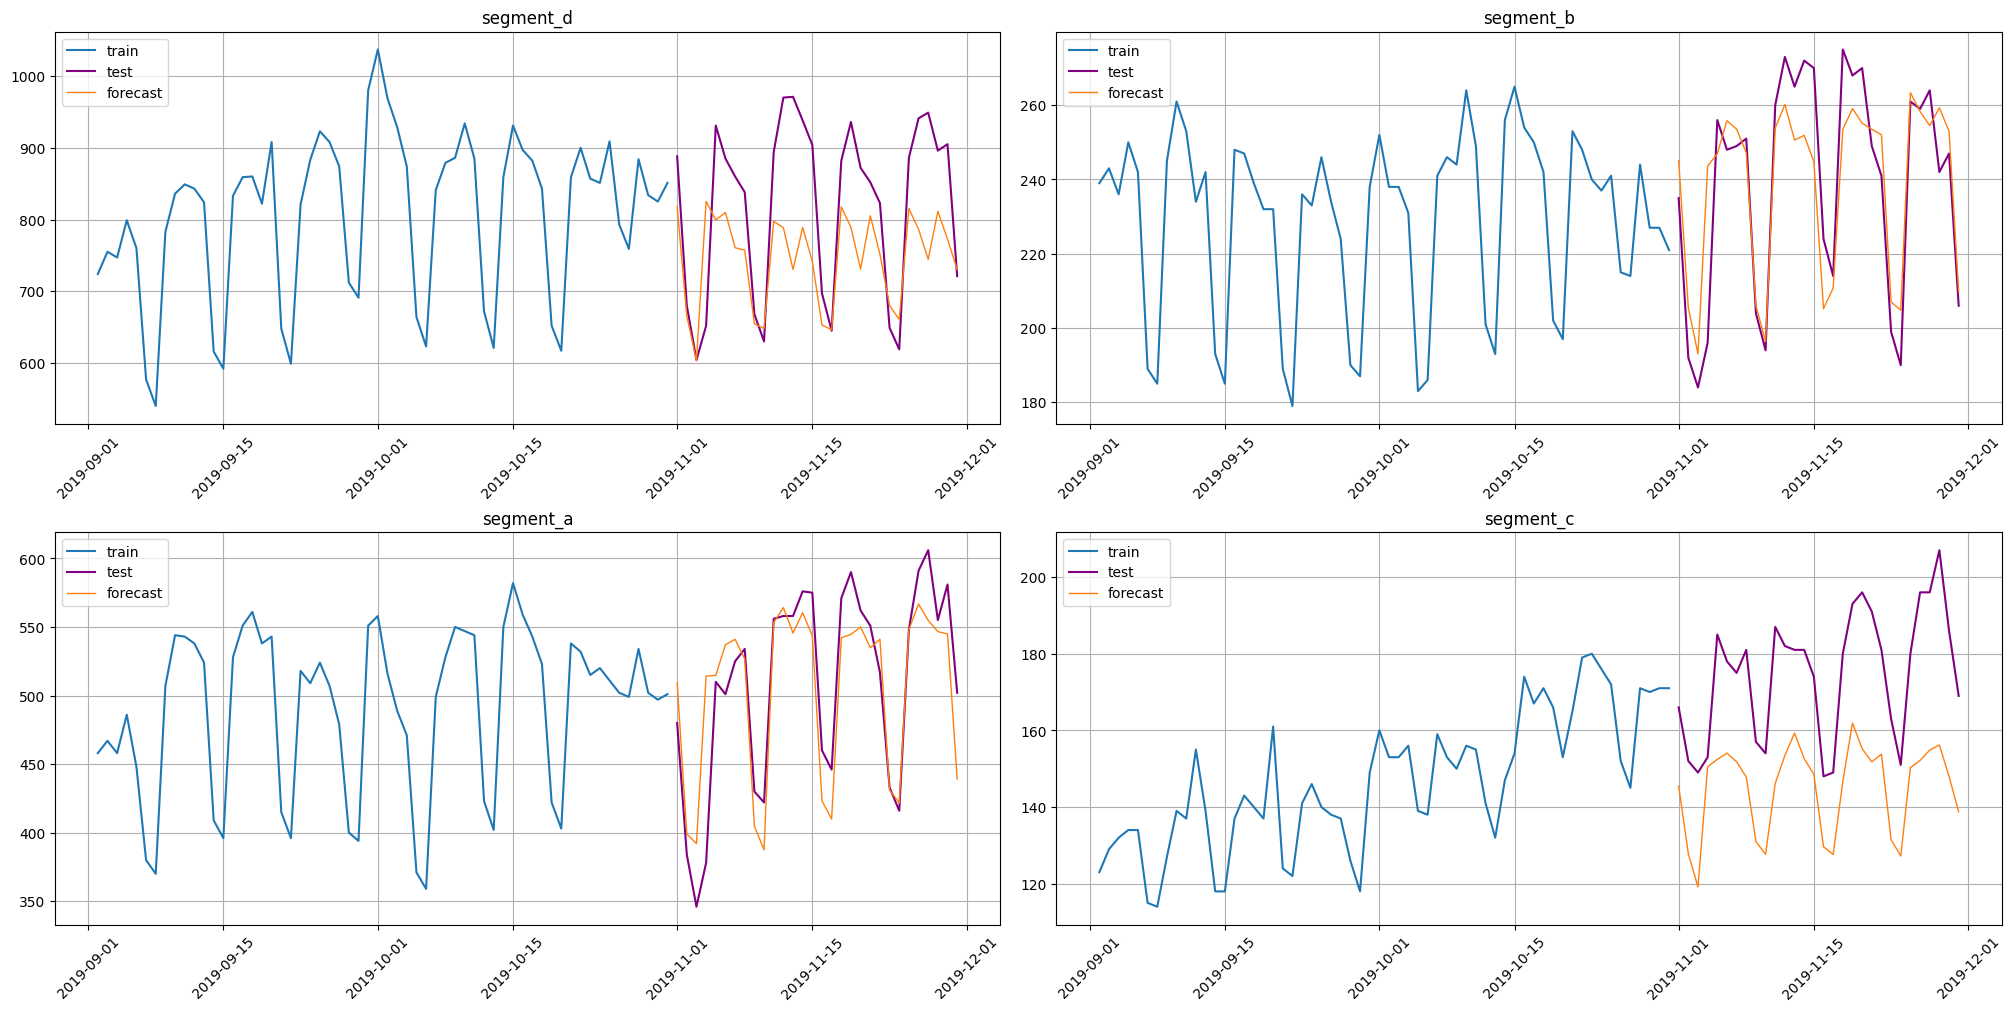

In [23]:
pipeline_loaded.fit(new_ts)
forecast_new_ts = pipeline_loaded.forecast()

plot_forecast(forecast_ts=forecast_new_ts, test_ts=test_ts, train_ts=new_ts, n_train_samples=HORIZON * 2)

In [24]:
smape(y_true=test_ts, y_pred=forecast_new_ts)

{'segment_d': 11.162075802124274,
 'segment_b': 4.703408652853966,
 'segment_a': 5.587809488492237,
 'segment_c': 18.357231604941372}

As we can see, these predictions are better. There are two main reasons:

1. Change of distribution. In a new data there can be some change of distribution that saved pipeline hasn't seen. In our case we can see a growth in segments `segment_c` and `segment_d` after the end of `old_ts`.
2. New pipeline has more data to learn.